# File sorter
This part contains code for sorting files from big AlphaFold runs. It sorts all files acording to sequence in chain B of PDB file, that coresponds to random peptide that had beed added to GLuc luciferase for complex predictions

In [2]:

from Bio import PDB
import numpy as np
from scipy.spatial import procrustes
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import zipfile
import os
import re
import glob
import shutil
import csv

This is for complexes

In [3]:
peptide=""
protein=""
protein_sequence="KPTENNEDFNIVAVASNFATTDLDADRGKLPGKKLPLEVLKEMEANARKAGCTRGCLICLSHIKCTPKMKKFIPGRCHTYEGDKESAQGGIGEAIVDIPEIPGFKDLEPMEQFIAQVDLCVDCTTGCLKGLANVQCSDLLKKWLPQRCATFASKIQGQVDKIKGAGGD"

In [4]:


amino_acid_short= {

"ALA":"A",
"ARG":"R",
"ASN":"N",
"ASP":"D",
"CYS":"C",
"GLU":"E",
"GLN":"Q",
"GLY":"G",
"HIS":"H",
"ILE":"I",
"LEU":"L",
"LYS":"K",
"MET":"M",
"PHE":"F",
"PRO":"P",
"SER":"S",
"THR":"T",
"TRP":"W",
"TYR":"Y",
"VAL":"V"
}


def extract_protein_sequence(input_folder):

    # Define a regular expression pattern to match folder names
    folder_pattern = re.compile(r'^output_[a-zA-Z0-9_]+$')

    # Define a regular expression pattern to match file names with a number in the specified range
    pdb_file_pattern = re.compile(r'^sequences_(\d+).*.pdb$')

    # Walk through the input folder and its subdirectories
    for root, dirs, files in os.walk(input_folder):
        for folder in dirs:
            # Check if the folder name matches the pattern
            if folder_pattern.match(folder):
                folder_path = os.path.join(root, folder)

                # Walk through the matching folder and extract files
                for _, _, filenames in os.walk(folder_path):
                    for filename in filenames:
                        # Check if the file name matches the pattern and the number is in the specified range
                        match = pdb_file_pattern.match(filename)
                        if match:
                            sequence_number = int(match.group(1))
                            file_path=os.path.join(folder_path, filename)
                            chain_b_sequence=extract_sequence_from_pdb(file_path)
                            directory_path=os.path.join(root, chain_b_sequence)

                            file_to_transfer_pattern =re.compile(r'^sequences_%d_.*' % sequence_number)

                            if not os.path.exists(directory_path):
                                os.makedirs(directory_path)
                                print(f"Created directory: {directory_path}")
                                for _, _, filenames in os.walk(folder_path):
                                    for filename in filenames:

                                        # Check if the file name matches the pattern and the number is in the specified range
                                        match = file_to_transfer_pattern.match(filename)
                                        if match:
                                            file_path=os.path.join(folder_path, filename)
                                            new_file_path=os.path.join(directory_path, filename)
                                            shutil.copyfile(file_path, new_file_path)
                            




def extract_sequence_from_pdb(input_pdb):
    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure('protein', input_pdb)

    # Assume only one model in the structure
    model = structure[0]

    # Extract sequences from chain B
    chain_b_sequences = []
    for chain in model:
        if chain.id == 'B':
            for residue in chain:
                if PDB.is_aa(residue):
                    chain_b_sequences.append(residue.get_resname())
    for i in range(len(chain_b_sequences)):
        chain_b_sequences[i]=amino_acid_short[chain_b_sequences[i]]
    global peptide
    peptide=chain_b_sequences


    return "".join(chain_b_sequences)

# Example usage:

input_folder = 'C:\\Users\\Juryx\\Desktop\\Output files\\Long Multimer'
#extract_protein_sequence(input_folder)


This is for Peptides on linker

# Variance of models

This part of code goes through all folders that contains data, and compares the pdb files. This result in determining of variance between models. We want this variance to bo as lower as it can be, because that indicates that models are "thinking" the same and that random peptide has valid conections on one exact spot.

In [5]:
import numpy as np
from scipy.spatial.transform import Rotation as R
import copy

def procrustes_analysis(Y, X, t):
    """
    Perform Procrustes analysis to find the optimal rigid transformation (rotation and translation)
    that aligns one set of 3D points (X) to another set of 3D points (Y).

    Args:
    X (numpy.ndarray): Numpy array of shape (N, 3) representing the first set of 3D points.
    Y (numpy.ndarray): Numpy array of shape (N, 3) representing the second set of 3D points.

    Returns:
    numpy.ndarray: The rotation matrix (3x3) and translation vector (3x1) as a tuple.
    """
    X=X[37:t-5]
    Y=Y[37:t-5]
    # Center both sets of points to their respective centroids
    centroid_X = np.mean(X, axis=0)
    centroid_Y = np.mean(Y, axis=0)
    X_centered = X - centroid_X
    Y_centered = Y - centroid_Y

    # Calculate the covariance matrix H
    H = np.dot(X_centered.T, Y_centered)

    # Use Singular Value Decomposition (SVD) to find the optimal rotation matrix
    U, s, Vt = np.linalg.svd(H)
    d=np.sign(np.linalg.det(np.dot(Vt.T,U.T)))
    R_optimal = np.dot(Vt.T,np.array([[1,0,0],[0,1,0],[0,0,d]]))
    R_optimal = np.dot(R_optimal, U.T)
    # Calculate the optimal translation vector
    t_optimal = centroid_Y - np.dot(R_optimal,centroid_X)
    return R_optimal, t_optimal

In [6]:
def get_pdb_file_paths(folder_path):
    pdb_paths = []

    # Iterate through all files and directories in the given folder
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            # Check if the file has a .pdb extension
            if file.endswith(".pdb"):
                # Construct the full path to the .pdb file and add it to the list
                pdb_path = os.path.join(root, file)
                pdb_paths.append(pdb_path)

    return pdb_paths

import math
def error_between_proteins(protein1,protein2):
  distances=[]
  for x in range(0,len(protein1)):
    distances.append(math.sqrt((protein1[x][2]-protein2[x][2])**2+(protein1[x][1]-protein2[x][1])**2+(protein1[x][0]-protein2[x][0])**2))
  return np.mean(distances)





In [7]:
t = 168  # Global variable representing the starting point in the models

def load_models(path):
    """
    Load protein models from PDB files.

    Parameters:
    - path: The path to the directory containing PDB files.

    Returns:
    - models: Array of predicted protein models.
    """
    models = []  # Array to store predicted proteins
    pdb_paths = get_pdb_file_paths(path)
    pdb_parser = PDB.PDBParser(QUIET=True)
    
    # Iterate through PDB files
    for path in pdb_paths:
        prot = pdb_parser.get_structure('protein', path)
        residue_atoms = []
        residue_centroids = []
        
        # Iterate through the structure hierarchy
        for model in prot:
            for chain in model:
                for residue in chain:
                    n = 0
                    sum_coord = [0, 0, 0]
                    
                    # Iterate through atoms in a residue
                    for atom in residue:
                        residue_atoms.append(atom.get_coord())
                        sum_coord += atom.get_coord()
                        n += 1
                    residue_centroids.append(sum_coord / n)
        models.append(residue_centroids)
    return models

def model_variance(models):
    """
    Compute variance between protein models.

    Parameters:
    - models: Array of protein models.

    Returns:
    - model_variance: Matrix representing variance between models.
    """
    results = np.zeros((len(models), len(models)))
    
    # Iterate through pairs of models
    for i in range(len(models)):
        for j in range(i,len(models)):
            model_to_transform = copy.deepcopy(models[i])
            R_optimal, t_optimal = procrustes_analysis(np.array(models[j]), np.array(models[i]), t)
            
            # Apply Procrustes transformation to the model
            for x in range(len(model_to_transform)):
                model_to_transform[x] = np.dot(model_to_transform[x], R_optimal.T) + t_optimal
            
            # Compute distance between transformed model and the target model
             
            dist = error_between_proteins(model_to_transform[t:], models[j][t:])
            results[i, j] =dist
            results[j, i] =dist
    
    model_variance = results / (len(models[0]) - t)
    return model_variance

def distance_to_keypoint(model, keypoint):
    """
    Compute the mean distance from luc to keypoints in a protein model.

    Parameters:
    - model: Protein model.
    - keypoint: List of keypoint indices.

    Returns:
    - mean_distance: Mean distance to keypoints.
    """
    distances = []
    luc = model[:t]
    peptide = model[t:]
    
    # Iterate through keypoints
    for x in keypoint:
        distance_to_residue = []
        
        # Iterate through residues in the peptide
        for y in range(len(peptide)):
            distance_to_residue.append(math.sqrt((luc[x][2]-peptide[y][2])**2+(luc[x][1] - peptide[y][1])**2 + (luc[x][0] - peptide[y][0])**2))
        distances.append(distance_to_residue)
    return distances

def compute_distances_to_keypoints(model,whole_peptide=False,whole_cavity=False):
    """
    Compute mean distances to predefined keypoints in a protein model.

    Parameters:
    - model: Protein model.

    Returns:
    - distances: List of mean distances to keypoints.
    """
    distances = []

    if whole_peptide==True:
        keypoints=np.arange(0,t)
        keypoints=[keypoints.tolist()]
    if whole_cavity==True:
        keypoints=[[13],[60],[61],[64],[65],[76],[77],[78],[117]]
    else:
        keypoints = [
                [65, 78],
                [13, 61],
                [13, 64],
                [61, 78]
                
        ]

    
    # Iterate through keypoints and compute distances
    for x in keypoints:
        distances.append(distance_to_keypoint(model, x))

    return distances


def compute_minimum_distance_criterion(models):
    """
    Compute and print maximum variance and mean distances to keypoints for a set of protein models.

    Parameters:
    - models: Array of protein models.
    """
    
    distances = []
    
    # Iterate through models and compute distances
    for model in models:
        distances.append(np.array((compute_distances_to_keypoints(model,whole_cavity=True))))
    for x in range(len(models)):
        max=np.max(np.min(distances[x],axis=2))
        mean=np.mean(np.min(distances[x],axis=2))

    return max,mean

def find_same_charge_close_proximity(models):
    for model in models:
        criterion=0
        global peptide
        positive_charge=["R","H","K"]
        negative_charge=["D","E"]
        
        indices_positive = []
        indices_negative = []
        for i in range(len(peptide)):
            if peptide[i] in positive_charge:
                indices_positive.append(i)
            if peptide[i] in negative_charge:
                indices_negative.append(i)
        print("[PEPTIDE] Number of pos residues: "+str(len(indices_positive))+", number of neg residues: "+ str(len(indices_negative)))
        
        if len(indices_positive)+len(indices_negative)>0:
            distances=np.array(compute_distances_to_keypoints(model,whole_peptide=True))
            distances=distances[0]
            if len(indices_positive)>0:
                for x in indices_positive:
                    sorted_indices = np.argsort(distances[:,x])  # Indices of the sorted array
                    top_3_indices = sorted_indices[:3]   # Indices of the top 3 minimum values
                    for y in top_3_indices:
                        
                        if protein_sequence[y] in positive_charge:
                            if distances[y][x]<4:
                                criterion+=1
                            else:
                                criterion+=0

            if len(indices_negative)>0:
                for x in indices_negative:
                    sorted_indices = np.argsort(distances[:,x])  # Indices of the sorted array
                    top_3_indices = sorted_indices[:3]   # Indices of the top 3 minimum values
                    for y in top_3_indices:
                        if protein_sequence[y] in negative_charge:
                            if distances[y][x]<4:
                             criterion+=1
                            else:
                                criterion+=0
                        

        return criterion
def compute_criterion(models):
    """
    Compute and print maximum variance and mean distances to keypoints for a set of protein models.

    Parameters:
    - models: Array of protein models.
    """
    variance = model_variance(models)
    distances = []
    
    # Iterate through models and compute distances
    for model in models:
        distances.append(compute_distances_to_keypoints(model))
    mean_distance = np.mean(distances, axis=0)

    print("Maximum variance:", np.max(variance))
    print("Mean distance to keypoint 1:", mean_distance[0])
    print("Mean distance to keypoint 2:", mean_distance[1])
    print("Mean distance to keypoint 3:", mean_distance[2])
    print("Mean distance to keypoint 4:", mean_distance[3])
    return_list= [np.max(variance),mean_distance[0],mean_distance[1],mean_distance[2],mean_distance[3]]
    return return_list


In [8]:
pred_protein_template = load_models("C:\\Users\Juryx\\OneDrive\\pdb_template")

In [9]:
import json
import numpy as np

def load_json_as_numpy(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
        np_array = np.array(data['predicted_aligned_error'])
    return np_array
def compute_pae(file):
    # Example usage:
    json_file = file
    pae_array = load_json_as_numpy(json_file)
    peptide_error=pae_array[t:,:t]
    print(peptide_error)


    # Mean of Predicted Values
    mean_predicted = np.mean(peptide_error)

    # Standard Deviation of Predicted Values
    std_predicted = np.std(peptide_error)

    # Range of Predicted Values
    range_predicted = np.max(peptide_error) - np.min(peptide_error)

    # Coefficient of Variation (CV)
    cv_predicted = std_predicted / mean_predicted

    print("Mean of Predicted Values:", mean_predicted)
    print("Standard Deviation of Predicted Values:", std_predicted)
    print("Range of Predicted Values:", range_predicted)
    print("Coefficient of Variation (CV) of Predicted Values:", cv_predicted)

    return mean_predicted,std_predicted,range_predicted,cv_predicted

def luc_deformation(models):
    for model in models:
        global pred_protein_template
        
        
        R_optimal, t_optimal = procrustes_analysis(model, pred_protein_template[0], t)

    # Apply the transformation matrix to the entire set2
        model = np.dot(model, R_optimal.T)
        model = model + t_optimal
        return error_between_proteins(model[10:t-15],pred_protein_template[0][10:t-15])

In [10]:

input_folder="C:\\Users\\Juryx\\Desktop\\Output files\\Long Multimer"
output_directory = 'C:\\Users\\Juryx\\Desktop\\Output files\\'
csv_file_path = os.path.join(output_directory, 'output_multimer_long.csv')


for root, dirs, files in os.walk(input_folder):
        for folder in dirs:
            with open(csv_file_path, mode='a', newline='') as csv_file:
                criterion=[]
                folder_path = os.path.join(root, folder)
                print(folder_path)
                models = load_models(folder_path)
                #criterion=compute_mean_criterion(models)
                proximity_same_charge=find_same_charge_close_proximity(models)
                max,mean=compute_minimum_distance_criterion(models)
                
                for file in os.listdir(folder_path):
                    if file.endswith('.json') and 'predicted_aligned_error' in file:
                        mean_predicted,std_predicted,range_predicted,cv_predicted=compute_pae(os.path.join(folder_path, file))
                        criterion.append(mean_predicted)
                        criterion.append(max)
                        criterion.append(mean)
                        criterion.append(proximity_same_charge)
                        criterion.append(luc_deformation(models))
                        criterion.append(folder)
                        
                if criterion!=[]:
                    csv_writer = csv.writer(csv_file)
                    csv_writer.writerow(criterion)




  

C:\Users\Juryx\Desktop\Output files\Long Multimer\AAAAAHEPIKYGCLICSHLTDHTWRVSFIK
[PEPTIDE] Number of pos residues: 0, number of neg residues: 0
[[28.16 27.48 27.23 ... 25.05 25.45 26.05]
 [28.22 27.09 26.97 ... 23.86 24.59 25.23]
 [28.36 27.5  26.97 ... 22.64 24.09 24.75]
 ...
 [29.81 29.56 29.33 ... 24.45 25.09 25.5 ]
 [30.03 29.91 29.48 ... 25.98 26.58 27.03]
 [30.23 29.97 29.73 ... 26.62 27.06 27.19]]
Mean of Predicted Values: 20.547901305683563
Standard Deviation of Predicted Values: 4.041946591758492
Range of Predicted Values: 21.56
Coefficient of Variation (CV) of Predicted Values: 0.19670848772475305
C:\Users\Juryx\Desktop\Output files\Long Multimer\AACIANMACDHHDDNITYNTMDVTALQN
[PEPTIDE] Number of pos residues: 0, number of neg residues: 0
[[30.94 30.77 30.73 ... 26.66 26.77 27.  ]
 [31.06 30.88 30.67 ... 26.14 26.03 26.94]
 [31.11 30.84 30.67 ... 25.73 26.08 26.28]
 ...
 [31.03 30.72 30.84 ... 26.25 26.78 27.12]
 [31.25 31.05 30.92 ... 26.81 27.3  27.81]
 [31.27 31.19 31.25 ...

KeyboardInterrupt: 

In [ ]:
import os
import pandas as pd
import seaborn as sns



def analyze_criterion(csv_file_path):
    


    # Define the column names
    column_names = ['PAE_MEAN','MAXIMUM_OF_MIN_DISTANCES','MEAN_OF_MIN_DISTANCES','proximity_same_charge','deformation','peptide'] 

    # Load the CSV file into a pandas DataFrame with specified column names
    df = pd.read_csv(csv_file_path, names=column_names)
    print("Number of peptides:",len(df))
    df['PRODUCT_PAE_MAX'] = df['PAE_MEAN'] * df['MAXIMUM_OF_MIN_DISTANCES']
    df['PRODUCT_PAE_MEAN'] = df['PAE_MEAN'] * df['MEAN_OF_MIN_DISTANCES']
    # Find the top 10 minimum values from column 'C1' and their corresponding 'peptide' values
    top_10_min_values = df.nsmallest(10, 'PAE_MEAN')

    # Print the result
    print(top_10_min_values[['peptide', 'PAE_MEAN']])

    top_10_min_values = df.nsmallest(10, 'MAXIMUM_OF_MIN_DISTANCES')

    # Print the result
    print(top_10_min_values[['peptide', 'MAXIMUM_OF_MIN_DISTANCES']])

    top_10_min_values = df.nsmallest(10, 'MEAN_OF_MIN_DISTANCES')

    # Print the result
    print(top_10_min_values[['peptide', 'MEAN_OF_MIN_DISTANCES']])


    # Define the columns for which you want to create distribution plots
    columns_to_plot = ['PAE_MEAN', 'MAXIMUM_OF_MIN_DISTANCES', 'MEAN_OF_MIN_DISTANCES',"PRODUCT_PAE_MAX","PRODUCT_PAE_MEAN","deformation"]

    # Set up the figure and axes for subplots
    fig, axes = plt.subplots(nrows=len(columns_to_plot), ncols=1, figsize=(10, 8))


    for i, column in enumerate(columns_to_plot):
        # Plot histogram with KDE
        sns.histplot(df[column], ax=axes[i], kde=True)
        axes[i].set_title(f'Distribution of {column}')
        
        # Add a red vertical line for the mean
        mean_value = df[column].mean()
        axes[i].axvline(mean_value, color='red', linestyle='--', label=f'Mean: {mean_value:.2f}')
        
        # Add a green vertical line for the median
        median_value = df[column].median()
        axes[i].axvline(median_value, color='green', linestyle='--', label=f'Median: {median_value:.2f}')
        
        # Add an orange vertical line for the maximum
        max_value = df[column].max()
        axes[i].axvline(max_value, color='orange', linestyle='--', label=f'Maximum: {max_value:.2f}')
        
        # Add an orange vertical line for the minimum
        min_value = df[column].min()
        axes[i].axvline(min_value, color='orange', linestyle='--', label=f'Minimum: {min_value:.2f}')
        
        axes[i].legend(loc='upper right')  # Move legend to the upper right

    plt.tight_layout()
    plt.show()

    # Loop through each column and create distribution plot
    for column in columns_to_plot:
        # Create a new figure and axis for each plot
        fig, ax = plt.subplots(figsize=(8, 6))
        
        # Plot histogram with KDE
        sns.histplot(df[column], kde=True, ax=ax)
        ax.set_title(f'Distribution of {column}')
        
        # Add a red vertical line for the mean
        mean_value = df[column].mean()
        ax.axvline(mean_value, color='red', linestyle='--', label=f'Mean: {mean_value:.2f}')
        
        # Add a green vertical line for the median
        median_value = df[column].median()
        ax.axvline(median_value, color='green', linestyle='--', label=f'Median: {median_value:.2f}')
        
        # Add an orange vertical line for the maximum
        max_value = df[column].max()
        ax.axvline(max_value, color='orange', linestyle='--', label=f'Maximum: {max_value:.2f}')
        
        # Add an orange vertical line for the minimum
        min_value = df[column].min()
        ax.axvline(min_value, color='purple', linestyle='--', label=f'Minimum: {min_value:.2f}')
        
        # Move legend to the upper right
        ax.legend(loc='upper right')

    plt.tight_layout()
    plt.show()




    top_10_max_values = df.nlargest(10, 'PAE_MEAN')

    # Print the result
    print(top_10_max_values[['peptide', 'PAE_MEAN']])

    top_10_max_values = df.nlargest(10, 'MAXIMUM_OF_MIN_DISTANCES')

    # Print the result
    print(top_10_max_values[['peptide', 'MAXIMUM_OF_MIN_DISTANCES']])

    top_10_max_values = df.nlargest(10, 'MEAN_OF_MIN_DISTANCES')

    # Print the result
    print(top_10_max_values[['peptide', 'MEAN_OF_MIN_DISTANCES']])

    df_sorted = df.sort_values(by='MEAN_OF_MIN_DISTANCES', ascending=True)

    # Calculate the index of the top 5% rows
    top_5_percent_index = int(0.05 * len(df_sorted))

    # Get the top 5% rows
    top_5_percent = df_sorted.head(top_5_percent_index)
    print("Top 5 percent by MEAN_OF_MIN_DISTANCES")
    print("Number of peptides in top 5% :",len(top_5_percent))
    print(top_5_percent[['peptide', 'MEAN_OF_MIN_DISTANCES']])
    # Plot the top 5% rows
    sns.histplot(top_5_percent['MEAN_OF_MIN_DISTANCES'], label='Top 5%')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Top 5% of Data based on MEAN_OF_MIN_DISTANCES')
    plt.legend()
    plt.grid(True)
    plt.show()




    df_sorted = df.sort_values(by='MAXIMUM_OF_MIN_DISTANCES', ascending=True)

    # Calculate the index of the top 5% rows
    top_5_percent_index = int(0.05 * len(df_sorted))

    # Get the top 5% rows
    top_5_percent = df_sorted.head(top_5_percent_index)
    print("Top 5 percent by MAXIMUM_OF_MIN_DISTANCES")
    print("Number of peptides in top 5% :",len(top_5_percent))
    print(top_5_percent[['peptide', 'MAXIMUM_OF_MIN_DISTANCES']])
    # Plot the top 5% rows
    sns.histplot(top_5_percent['MAXIMUM_OF_MIN_DISTANCES'], label='Top 5%')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Top 5% of Data based on MAXIMUM_OF_MIN_DISTANCES')
    plt.legend()
    plt.grid(True)
    plt.show()


Number of peptides: 1749
                              peptide   PAE_MEAN
1057      PEKMAKSCVCPNYCGIMFTVYSHPEMA  10.292482
1728  YRLEEMMWVNGMNWAAATKVSKILLSWHKWT  11.208055
413       FRDFSNNFHRIFEAQQHAMWYMSAWKR  11.324959
1360  SRFFNGVPLYWTDMYSMRWADIATWLNIKSQ  11.760740
797       LFARPTVAHVWTKMKWISMSIYHRPKE  11.952513
1061     PERYTLAYWYLSHRVGETSSNSVETGVF  12.190298
1266   RRWTPEQRGFMCQYWLNGDNRKQAWSVKLI  12.571917
1649   WYRNKRTRGVWDVSYGAWTWAQIWSEQGQT  12.617715
526     HEINDHIMWKHYESIESFRHRGTYNNKKV  12.745357
715     KGWYWLAKVEHIFQGWRIACEAQYAEEPC  12.803817
                              peptide  MAXIMUM_OF_MIN_DISTANCES
205      DHKNFRGPHPSVQMMEKAPTCHLDLKEM                  8.972172
307      ELEEFMWMFGNRQVHNSITNKTLVRILG                  9.091291
884      MCQGQVALIRWDMCPRFRALKQIFKVIP                  9.158640
1090  PMVTWMAAMIYLPHACEIPQWSYYRYKPWYM                  9.254167
593      HWNADVQDWGQCFGHPAHPIILLMLFYH                  9.292376
1395   TCFLWSVPDGCLYPDVKYVEQCATKAYGRK               

c:\Users\Juryx\miniconda3\envs\ais\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Juryx\miniconda3\envs\ais\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Juryx\miniconda3\envs\ais\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Juryx\miniconda3\envs\ais\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

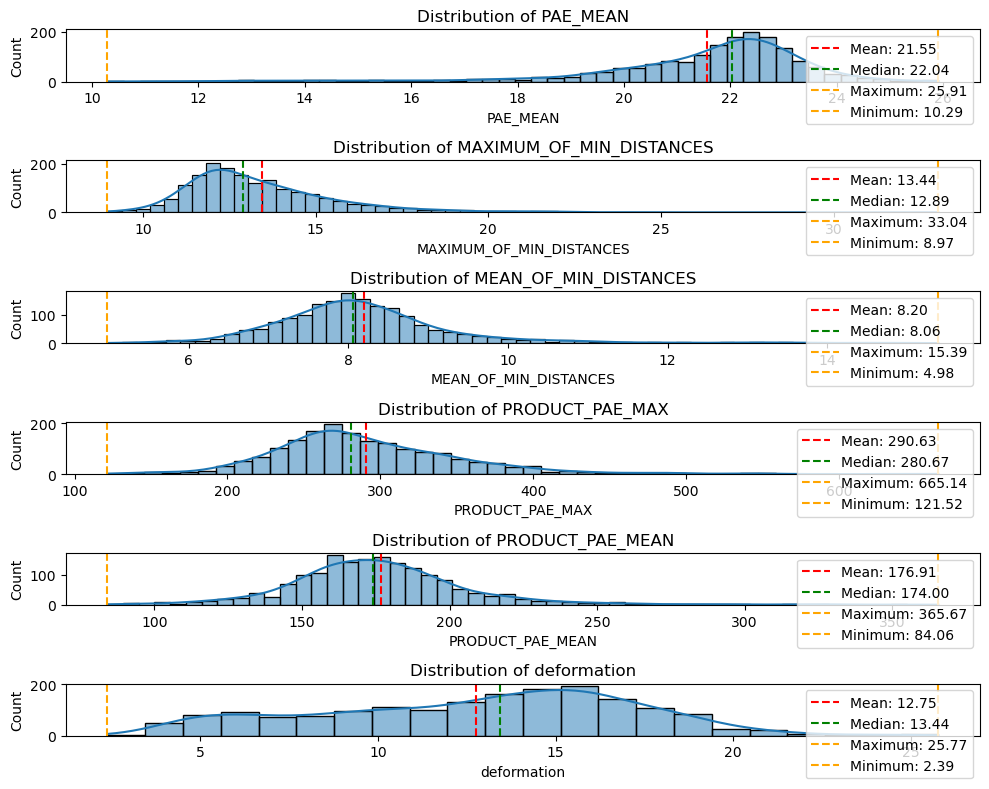

c:\Users\Juryx\miniconda3\envs\ais\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Juryx\miniconda3\envs\ais\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Juryx\miniconda3\envs\ais\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Juryx\miniconda3\envs\ais\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

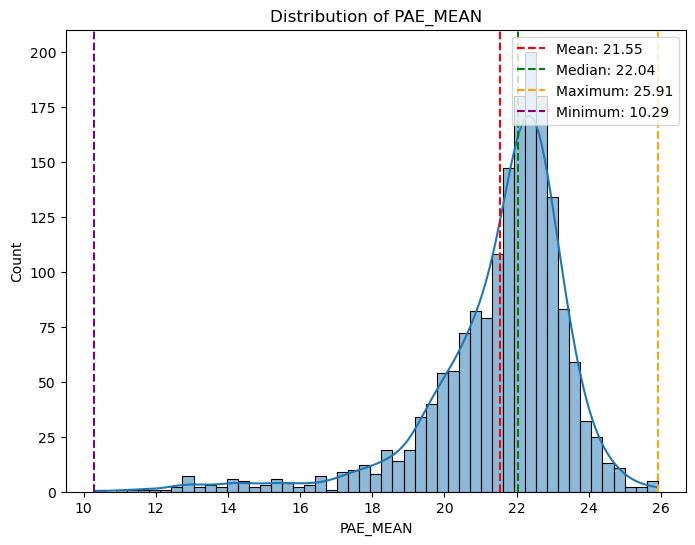

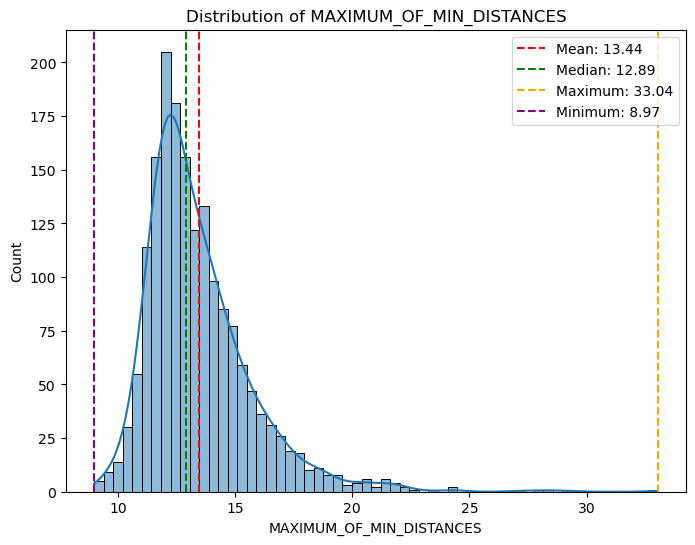

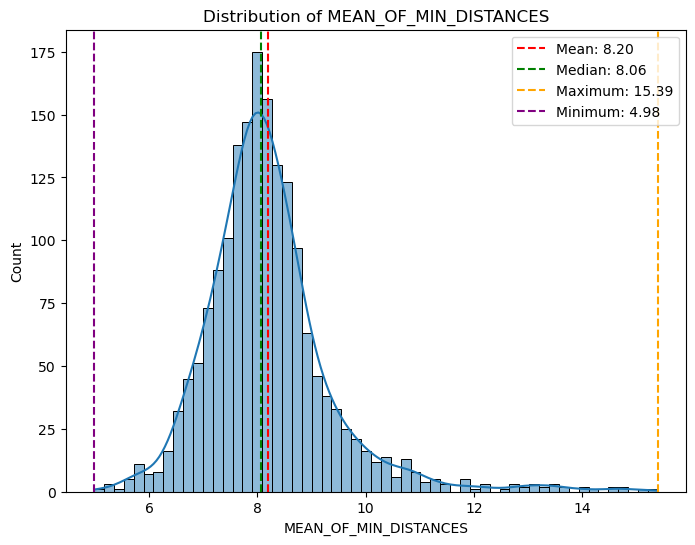

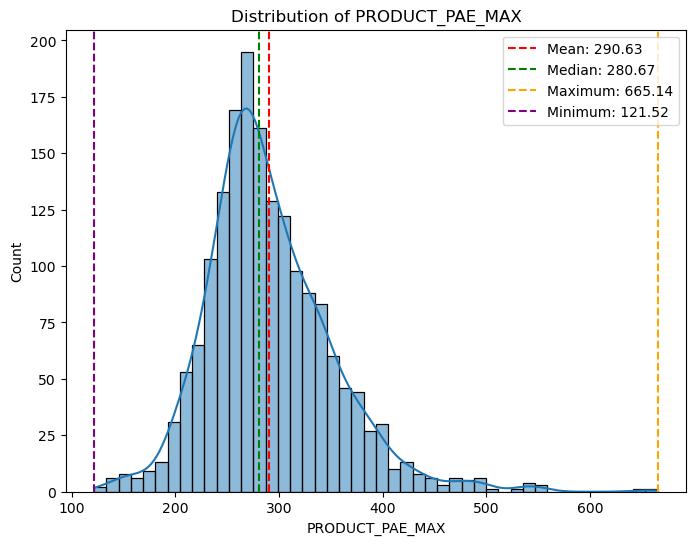

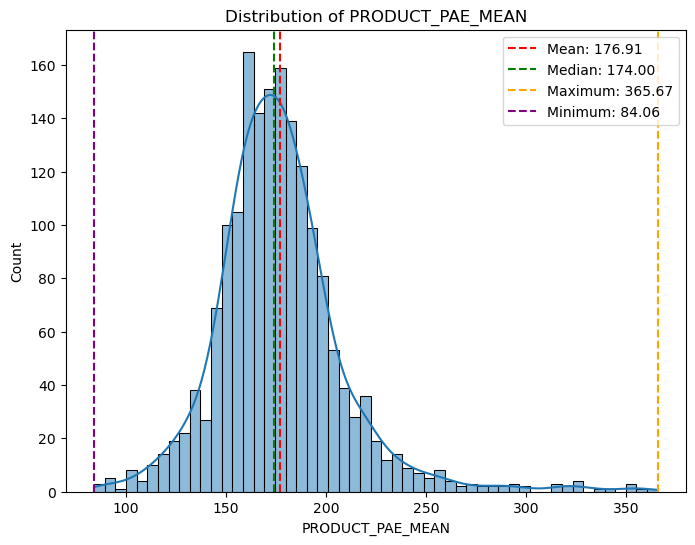

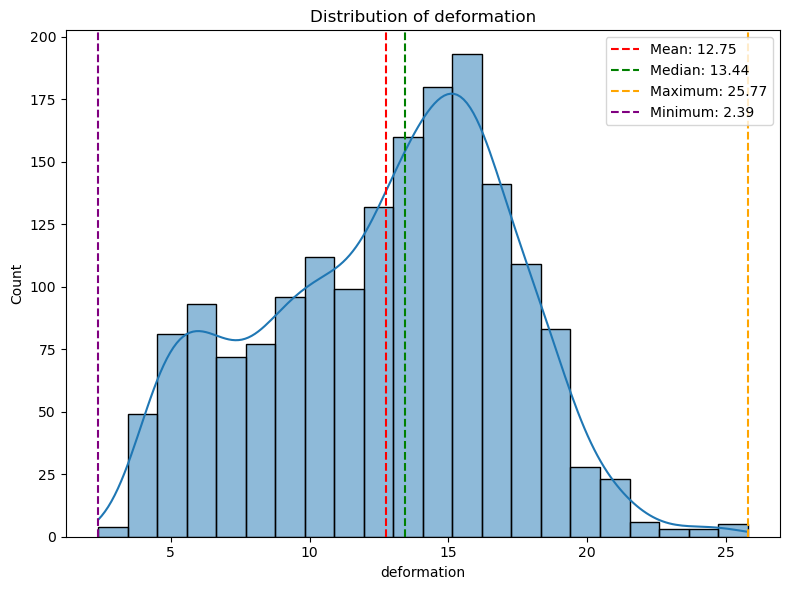

                              peptide   PAE_MEAN
1489     VHVQCTQMAGERQINSRRKCCVQKHRAY  25.911143
1608      WKRDKRRCKRGRNKQPYRMTTAEDSKM  25.818323
1330   SISYIERSDPTTISNHQNHPAHAVEINTHY  25.756619
1635      WTPSFGKTMPKRPARSEAPLSVVAWRE  25.742220
1195      QWRRNVSPYPLKIHKRKTASMNHGTKW  25.669072
133       CMPEGRRINRTHWCIRCNHPISVRVKC  25.409725
64      ARHLGSTINLQFRTRSAHGRVTKESAESG  25.336182
183     DDQITDTNCPAKPRNVMYVVKPRSERRLG  25.264509
1492  VIEGYSRNTIVRMAPRQKTKECDCHDCHPWL  25.114355
1596        WHRIWPRDDADHHHPHEVSLQVSEM  24.961116
                              peptide  MAXIMUM_OF_MIN_DISTANCES
1264     RRLIVLPFYDCEGMKHIARAPVMLTCDH                 33.039008
540      HHGHCQILYYDQDSRDAFYYAGGQGIML                 29.206436
988       NILLIISVMTLPIAHDYGTHLAIRYII                 28.411956
359     FDVCFNKWWVNETIRWPANYWMIRLKCKV                 27.971687
1614      WMTGKVMHGTMMGQRGMQDQEHCWKWW                 27.104495
667       IRWQMLEFARDRVQASEMASPDGMEDW                 24.393103
393        FN

c:\Users\Juryx\miniconda3\envs\ais\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Juryx\miniconda3\envs\ais\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


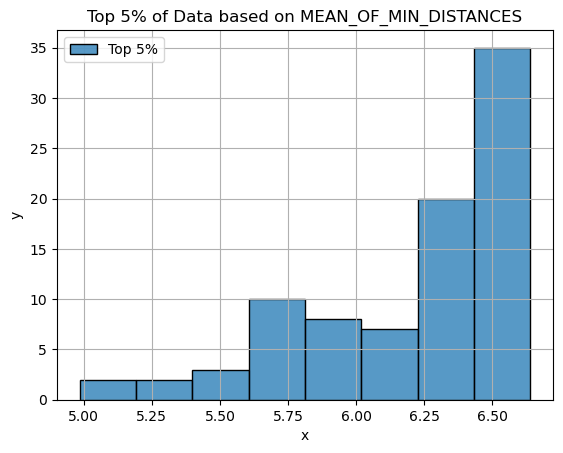

Top 5 percent by MAXIMUM_OF_MIN_DISTANCES
Number of peptides in top 5% : 87
                              peptide  MAXIMUM_OF_MIN_DISTANCES
205      DHKNFRGPHPSVQMMEKAPTCHLDLKEM                  8.972172
307      ELEEFMWMFGNRQVHNSITNKTLVRILG                  9.091291
884      MCQGQVALIRWDMCPRFRALKQIFKVIP                  9.158640
1090  PMVTWMAAMIYLPHACEIPQWSYYRYKPWYM                  9.254167
593      HWNADVQDWGQCFGHPAHPIILLMLFYH                  9.292376
...                               ...                       ...
526     HEINDHIMWKHYESIESFRHRGTYNNKKV                 10.838990
206      DHLVGQEVTPKRRFKCTIENSIMNRSAP                 10.839722
1728  YRLEEMMWVNGMNWAAATKVSKILLSWHKWT                 10.841937
473      GKEHIMFHQLKPFFYNVRFKLQFFDAGP                 10.843031
789   LCWSKRGKRKMKIERCEFTRTNLSNKPRGVM                 10.847274

[87 rows x 2 columns]


c:\Users\Juryx\miniconda3\envs\ais\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Juryx\miniconda3\envs\ais\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


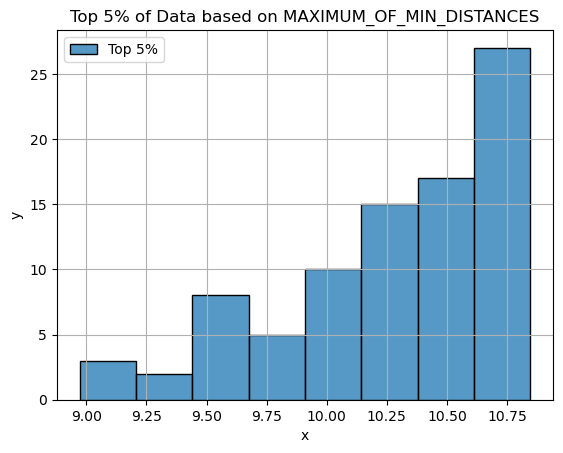

In [ ]:
output_directory = 'C:\\Users\\Juryx\\Desktop\\Output files'
csv_file_path = os.path.join(output_directory, 'output_multimer_long.csv')
analyze_criterion(csv_file_path)